# Estimate the explosion time from a spectral time series #

Import modules

In [1]:
import sncosmo
import numpy as np
from astropy.table import Table
import matplotlib.pyplot as plt

Specify the path to the SED time series. In this case it's one of the templates from experimental data and think of some value for the redshift and the peak MJD.

In [2]:
my_source_path = 'data/SEDs/MODEL03/SDSS-014492.SED.gz'
redshift = 0
peak_mjd = 5551378

load the SED time series into sncosmo

In [3]:
def sncosmo_source(source_path):
    sed = Table(np.loadtxt(source_path), names=['phase', 'wl', 'flux'])
    phase = np.unique(sed['phase'])
    disp = np.unique(sed['wl'])
    flux = sed['flux'].reshape(len(phase), len(disp))
    snc_source = sncosmo.TimeSeriesSource(phase, disp, flux, zero_before=True)
    return snc_source

In [4]:
source = sncosmo_source(my_source_path)

Asuming the peak time refers to the bolometric peak, construct a completly transparant bandpass to calculate the bolometric flux.

In [5]:
wavelength = [source.minwave(), source.maxwave()]
transmission = [1, 1]
complete_band = sncosmo.Bandpass(wavelength, transmission, name='complete band')

As the absolut amplitude of the flux doesn't matter, set it to an arbitrary value.

In [6]:
amp = 1e-1
source.set(amplitude=amp)

In order to draw the lightcurve, make a time array and calculate the bolometric flux for each step. Normalize the flux to the maximum.

In [7]:
step = 5000
time = np.linspace(source.minphase(), source.minphase()+50, step)
flux = source.bandflux(complete_band, time)
flux = flux / max(flux)

Draw the lightcurve

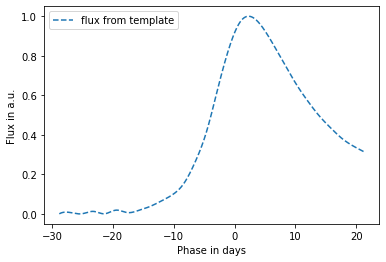

In [8]:
fig, ax = plt.subplots()
ax.plot(time, flux, label='flux from template', ls='--')
ax.set_xlabel('Phase in days')
ax.set_ylabel('Flux in a.u.')
ax.legend()
plt.show()
plt.close()

Create a sncosmo Model in order to be able to set the redshift

In [9]:
model = sncosmo.Model(source)

Set the redshift and the time parameter $t_0$, that fixes the lightcurve on the time axis. Construct a new bandpass and get the flux, analog to before.

In [10]:
model.set(z=redshift)
complete_band = sncosmo.Bandpass(
    [model.minwave(), model.maxwave()], 
    [1, 1], name='complete band redshifted'
)
redtime = np.linspace(model.mintime(), model.maxtime(), step)
redshifted_flux = model.bandflux(complete_band, time)
redshifted_flux = redshifted_flux / max(redshifted_flux)

Shift the time axis so that the maximum flux is at peak MJD

In [11]:
redtime = redtime - redtime[np.argmax(redshifted_flux)] + peak_mjd

Find the explosion time as the phase where the flux exceeds the rather arbitrary value $F_{threshold} = 0.001$

In [12]:
t_exp = min(redtime[redshifted_flux > 0.01])

Plot the result

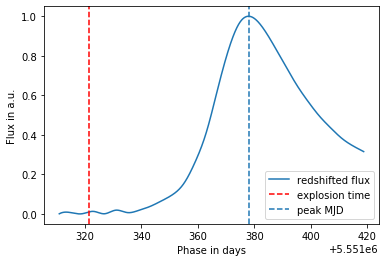

In [13]:
fig, ax = plt.subplots()
ax.plot(redtime, redshifted_flux, label='redshifted flux')
ax.axvline(t_exp, label='explosion time', ls='--', c='r')
ax.axvline(peak_mjd, label='peak MJD', ls='--')
ax.set_xlabel('Phase in days')
ax.set_ylabel('Flux in a.u.')
ax.legend()
plt.show()
plt.close()

Repeat with different parameters and a different time series, this time from MOSFiT.

In [14]:
my_source_path = 'data/SEDs/MODEL13/ibc_176.dat.gz'
redshift = 0.09
peak_mjd = 5551378

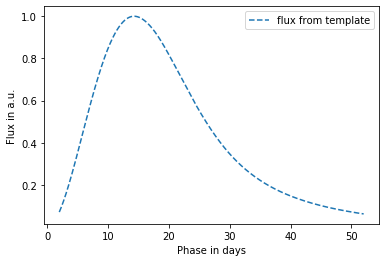

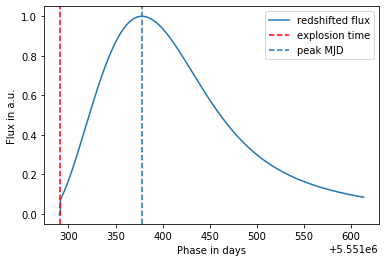

In [15]:
source = sncosmo_source(my_source_path)

wavelength = [source.minwave(), source.maxwave()]
transmission = [1, 1]
complete_band = sncosmo.Bandpass(wavelength, transmission, name='complete band')
amp = 1e-1
source.set(amplitude=amp)
step = 5000
time = np.linspace(source.minphase(), source.minphase()+50, step)
flux = source.bandflux(complete_band, time)
flux = flux / max(flux)

fig, ax = plt.subplots()
ax.plot(time, flux, label='flux from template', ls='--')
ax.set_xlabel('Phase in days')
ax.set_ylabel('Flux in a.u.')
ax.legend()
plt.show()
plt.close()

model = sncosmo.Model(source)
model.set(z=redshift)
complete_band = sncosmo.Bandpass(
    [model.minwave(), model.maxwave()], 
    [1, 1], name='complete band redshifted'
)
redtime = np.linspace(model.mintime(), model.maxtime(), step)
redshifted_flux = model.bandflux(complete_band, time)
redshifted_flux = redshifted_flux / max(redshifted_flux)
redtime = redtime - redtime[np.argmax(redshifted_flux)] + peak_mjd
t_exp = min(redtime[redshifted_flux > 0.01])

fig, ax = plt.subplots()
ax.plot(redtime, redshifted_flux, label='redshifted flux')
ax.axvline(t_exp, label='explosion time', ls='--', c='r')
ax.axvline(peak_mjd, label='peak MJD', ls='--')
ax.set_xlabel('Phase in days')
ax.set_ylabel('Flux in a.u.')
ax.legend()
plt.show()
plt.close()

Apparently some templates are generated from theroetical models and don't include the explosion time. But the explosion time in the original template is at $t=0$!
So in the case where the original template starts at a phase $t_{start} > 0$, for each explosion time estimation account for this difference in the observer frame: 
$$ t_{exp} = t_{exp, pre} - t_{start} \cdot (1+z) $$

2.004


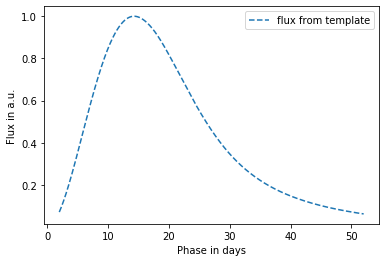

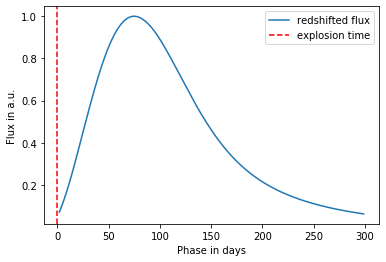

In [20]:
source = sncosmo_source(my_source_path)

wavelength = [source.minwave(), source.maxwave()]
transmission = [1, 1]
complete_band = sncosmo.Bandpass(wavelength, transmission, name='complete band')
amp = 1e-1
source.set(amplitude=amp)
step = 5000
time = np.linspace(source.minphase(), source.minphase()+50, step)
flux = source.bandflux(complete_band, time)
flux = flux / max(flux)
tstart = min(time[flux > 0.01])
print(tstart)

fig, ax = plt.subplots()
ax.plot(time, flux, label='flux from template', ls='--')
ax.set_xlabel('Phase in days')
ax.set_ylabel('Flux in a.u.')
ax.legend()
plt.show()
plt.close()

model = sncosmo.Model(source)
model.set(z=0, t0=0)
complete_band = sncosmo.Bandpass(
    [model.minwave(), model.maxwave()], 
    [1, 1], name='complete band redshifted'
)
redtime = np.linspace(model.mintime(), model.maxtime(), step)
redshifted_flux = model.bandflux(complete_band, time)
redshifted_flux = redshifted_flux / max(redshifted_flux)
# redtime = redtime - redtime[np.argmax(redshifted_flux)] + peak_mjd
t_exp_pre = min(redtime[redshifted_flux > 0.01])
t_exp = t_exp_pre - tstart * (1 + redshift) if tstart > 0 else t_exp_pre

fig, ax = plt.subplots()
ax.plot(redtime, redshifted_flux, label='redshifted flux')
ax.axvline(t_exp, label='explosion time', ls='--', c='r')
# ax.axvline(peak_mjd, label='peak MJD', ls='--')
ax.set_xlabel('Phase in days')
ax.set_ylabel('Flux in a.u.')
ax.legend()
plt.show()
plt.close()